<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Imports and Scripts

In [1]:
%%javascript
// ToC script
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
#Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')



In [3]:
# imports and constants
import json
import pickle
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import multiprocessing
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from statsmodels.stats.stattools import durbin_watson

# user imports
import sys
sys.path.append('../')
import data_processing.analysis_utils as ls_utils

# matplotlib configuration
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

## Display constants

In [4]:
agg_cols_change = ['active_apps_agg_change',
 'passive_apps_agg_change',
 'social_apps_agg_change',
 'work_dur_agg_change',
 'home_dur_agg_change',
 'religion_dur_agg_change',
 'exercise_dur_agg_change',                   
 'shopping_dur_agg_change',
 'other_dur_agg_change',
 'social_dur_agg_change',
 'sms_agg_change',
 'cal_agg_change',
# 'movt_agg_change',
# 'wkday_total_entropy_agg_change',
# 'wkend_entropy_agg_change',
 'movt_distance_agg_change',
 'movt_variance_agg_change',
 'movt_duration_agg_change'
]
sel_agg_cols = [x for x in agg_cols_change if 'fga' not in x]
groups = ['all', 'no_symp', 'soc_anx', 'gen_anx', 'dep_anx']

# Load data

In [5]:
gad_spin_corr = pd.read_pickle("~/lifesense/wave1_features/all_gad_spin_corr_unit.df")
rev_gad_spin_corr = pd.read_pickle("~/lifesense/wave1_features/all_rev_gad_spin_corr_unit.df")

phq_corr = pd.read_pickle("~/lifesense/wave1_features/all_phq_corr_unit.df")
rev_phq_corr = pd.read_pickle("~/lifesense/wave1_features/all_rev_phq_corr_unit.df")

In [6]:
gad_spin_corr['gad_diff'] = gad_spin_corr['gad_diff'].astype(float)
rev_gad_spin_corr['gad_diff'] = rev_gad_spin_corr['gad_diff'].astype(float)

In [7]:
# merge new movement columns
movt_cols =  ['movt_distance_agg_change',
              'movt_variance_agg_change',
              'movt_duration_agg_change']

gad_spin_gps = pd.read_pickle("~/lifesense/wave1_features/all_gad_spin_gps_corr.df")
rev_gad_spin_gps = pd.read_pickle("~/lifesense/wave1_features/all_rev_gad_spin_gps_corr.df")

phq_gps = pd.read_pickle("~/lifesense/wave1_features/all_phq_gps_corr.df")
rev_phq_gps = pd.read_pickle("~/lifesense/wave1_features/all_rev_phq_gps_corr.df")

print(gad_spin_corr.shape)
gad_spin_corr = gad_spin_corr.merge(gad_spin_gps[['pid', 'study_wk'] + movt_cols], 
                                    on=['pid', 'study_wk'], 
                                    how='left')
print(gad_spin_corr.shape)

print(rev_gad_spin_corr.shape)
rev_gad_spin_corr = rev_gad_spin_corr.merge(rev_gad_spin_gps[['pid', 'study_wk'] + movt_cols], 
                                            on=['pid', 'study_wk'], 
                                            how='left')
print(rev_gad_spin_corr.shape)

print(phq_corr.shape)
phq_corr = phq_corr.merge(phq_gps[['pid', 'study_wk'] + movt_cols], 
                                    on=['pid', 'study_wk'], 
                                    how='left')
print(phq_corr.shape)

print(rev_phq_corr.shape)
rev_phq_corr = rev_phq_corr.merge(rev_phq_gps[['pid', 'study_wk'] + movt_cols], 
                                            on=['pid', 'study_wk'], 
                                            how='left')
print(rev_phq_corr.shape)

(1335, 338)
(1335, 341)
(1335, 338)
(1335, 341)
(1632, 280)
(1632, 283)
(1632, 280)
(1632, 283)


# Reviewer A 2a: Correlations for only individuals with a change in symptoms

## Filter data to only changes

In [8]:
change_gad_spin_corr = gad_spin_corr[gad_spin_corr['gad_diff'] != 0]
change_rev_gad_spin_corr = rev_gad_spin_corr[rev_gad_spin_corr['gad_diff'] != 0]
print(change_gad_spin_corr.shape)
print(gad_spin_corr.shape)

(1127, 341)
(1335, 341)


In [9]:
change_phq_corr = phq_corr[phq_corr['phq_diff'] != 0]
change_rev_phq_corr = rev_phq_corr[rev_phq_corr['phq_diff'] != 0]
print(change_phq_corr.shape)
print(phq_corr.shape)

(1320, 283)
(1632, 283)


## SPIN

### Full population

In [10]:
ls_utils.display_all_corr(change_gad_spin_corr, agg_cols_change, 'spin_diff', method='pearson');
ls_utils.display_all_corr(change_gad_spin_corr, agg_cols_change, 'spin_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,820,0.008228,0.8140,0.9022,fdr_bh
1,passive_apps_agg_change,spin_diff,820,0.065680,0.0601*,0.4509,fdr_bh
2,social_apps_agg_change,spin_diff,820,-0.004298,0.9022,0.9022,fdr_bh
3,work_dur_agg_change,spin_diff,818,0.007769,0.8244,0.9022,fdr_bh
4,home_dur_agg_change,spin_diff,818,0.012145,0.7287,0.9022,fdr_bh
5,religion_dur_agg_change,spin_diff,818,0.033488,0.3388,0.6352,fdr_bh
6,exercise_dur_agg_change,spin_diff,818,-0.025161,0.4724,0.7873,fdr_bh
7,shopping_dur_agg_change,spin_diff,818,-0.035502,0.3105,0.6352,fdr_bh
8,other_dur_agg_change,spin_diff,818,0.039620,0.2577,0.6352,fdr_bh
9,social_dur_agg_change,spin_diff,818,-0.099325,0.0045*,0.0669*,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,820,-0.004795,0.8910,0.8910,fdr_bh
1,passive_apps_agg_change,spin_diff,820,0.106585,0.0022*,0.0336*,fdr_bh
2,social_apps_agg_change,spin_diff,820,0.010108,0.7726,0.8277,fdr_bh
3,work_dur_agg_change,spin_diff,818,-0.018951,0.5883,0.8277,fdr_bh
4,home_dur_agg_change,spin_diff,818,0.011469,0.7433,0.8277,fdr_bh
5,religion_dur_agg_change,spin_diff,818,0.013099,0.7083,0.8277,fdr_bh
6,exercise_dur_agg_change,spin_diff,818,0.018802,0.5913,0.8277,fdr_bh
7,shopping_dur_agg_change,spin_diff,818,0.030385,0.3854,0.8277,fdr_bh
8,other_dur_agg_change,spin_diff,818,0.028143,0.4215,0.8277,fdr_bh
9,social_dur_agg_change,spin_diff,818,-0.076543,0.0286*,0.1692,fdr_bh


### no_symp

In [11]:
sel_state_df = change_gad_spin_corr[change_gad_spin_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,215,-0.038319,0.5763,0.9753,fdr_bh
1,passive_apps_agg_change,spin_diff,215,0.107251,0.1169,0.6257,fdr_bh
2,social_apps_agg_change,spin_diff,215,0.020819,0.7615,0.9753,fdr_bh
3,work_dur_agg_change,spin_diff,215,0.025204,0.7133,0.9753,fdr_bh
4,home_dur_agg_change,spin_diff,215,0.016088,0.8146,0.9753,fdr_bh
5,religion_dur_agg_change,spin_diff,215,0.023925,0.7272,0.9753,fdr_bh
6,exercise_dur_agg_change,spin_diff,215,-0.012194,0.8589,0.9753,fdr_bh
7,shopping_dur_agg_change,spin_diff,215,-0.103856,0.1290,0.6257,fdr_bh
8,other_dur_agg_change,spin_diff,215,0.076817,0.2621,0.7863,fdr_bh
9,social_dur_agg_change,spin_diff,215,-0.094615,0.1669,0.6257,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,215,0.005348,0.9379,0.9973,fdr_bh
1,passive_apps_agg_change,spin_diff,215,0.169722,0.0127*,0.1904,fdr_bh
2,social_apps_agg_change,spin_diff,215,0.117162,0.0866*,0.4052,fdr_bh
3,work_dur_agg_change,spin_diff,215,-0.034874,0.6111,0.8333,fdr_bh
4,home_dur_agg_change,spin_diff,215,0.112405,0.1002,0.4052,fdr_bh
5,religion_dur_agg_change,spin_diff,215,-0.063705,0.3526,0.7644,fdr_bh
6,exercise_dur_agg_change,spin_diff,215,0.000230,0.9973,0.9973,fdr_bh
7,shopping_dur_agg_change,spin_diff,215,-0.007332,0.9149,0.9973,fdr_bh
8,other_dur_agg_change,spin_diff,215,0.045216,0.5096,0.7644,fdr_bh
9,social_dur_agg_change,spin_diff,215,-0.109908,0.1080,0.4052,fdr_bh


### soc_anx

In [12]:
sel_state_df = change_gad_spin_corr[change_gad_spin_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,232,0.067003,0.3095,0.6075,fdr_bh
1,passive_apps_agg_change,spin_diff,232,0.048941,0.4582,0.6873,fdr_bh
2,social_apps_agg_change,spin_diff,232,0.041771,0.5267,0.6976,fdr_bh
3,work_dur_agg_change,spin_diff,232,0.034174,0.6046,0.6976,fdr_bh
4,home_dur_agg_change,spin_diff,232,0.065033,0.3240,0.6075,fdr_bh
5,religion_dur_agg_change,spin_diff,232,0.177529,0.0067*,0.0503*,fdr_bh
6,exercise_dur_agg_change,spin_diff,232,-0.074164,0.2606,0.6075,fdr_bh
7,shopping_dur_agg_change,spin_diff,232,-0.117937,0.0730*,0.2190,fdr_bh
8,other_dur_agg_change,spin_diff,232,0.022089,0.7379,0.7906,fdr_bh
9,social_dur_agg_change,spin_diff,232,-0.158541,0.0156*,0.0782*,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,232,0.050105,0.4475,0.6698,fdr_bh
1,passive_apps_agg_change,spin_diff,232,0.165182,0.0117*,0.1762,fdr_bh
2,social_apps_agg_change,spin_diff,232,0.055819,0.3974,0.6623,fdr_bh
3,work_dur_agg_change,spin_diff,232,0.003850,0.9535,0.9609,fdr_bh
4,home_dur_agg_change,spin_diff,232,0.093618,0.1552,0.4656,fdr_bh
5,religion_dur_agg_change,spin_diff,232,0.098899,0.1331,0.4656,fdr_bh
6,exercise_dur_agg_change,spin_diff,232,0.072290,0.2728,0.5811,fdr_bh
7,shopping_dur_agg_change,spin_diff,232,0.025438,0.6999,0.8749,fdr_bh
8,other_dur_agg_change,spin_diff,232,0.110744,0.0924*,0.4620,fdr_bh
9,social_dur_agg_change,spin_diff,232,-0.146549,0.0256*,0.1920,fdr_bh


### gen_anx

In [13]:
sel_state_df = change_gad_spin_corr[change_gad_spin_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,222,-0.051796,0.4425,0.7641,fdr_bh
1,passive_apps_agg_change,spin_diff,222,-0.010962,0.8710,0.9332,fdr_bh
2,social_apps_agg_change,spin_diff,222,-0.050013,0.4584,0.7641,fdr_bh
3,work_dur_agg_change,spin_diff,221,-0.024147,0.7211,0.8320,fdr_bh
4,home_dur_agg_change,spin_diff,221,-0.036179,0.5927,0.8320,fdr_bh
5,religion_dur_agg_change,spin_diff,221,0.028493,0.6736,0.8320,fdr_bh
6,exercise_dur_agg_change,spin_diff,221,0.050741,0.4529,0.7641,fdr_bh
7,shopping_dur_agg_change,spin_diff,221,0.118121,0.0797*,0.3987,fdr_bh
8,other_dur_agg_change,spin_diff,221,0.051884,0.4428,0.7641,fdr_bh
9,social_dur_agg_change,spin_diff,221,-0.086905,0.1981,0.7163,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,222,-0.067418,0.3173,0.6337,fdr_bh
1,passive_apps_agg_change,spin_diff,222,0.044753,0.5071,0.6339,fdr_bh
2,social_apps_agg_change,spin_diff,222,-0.056946,0.3985,0.6337,fdr_bh
3,work_dur_agg_change,spin_diff,221,-0.072599,0.2826,0.6337,fdr_bh
4,home_dur_agg_change,spin_diff,221,-0.054227,0.4225,0.6337,fdr_bh
5,religion_dur_agg_change,spin_diff,221,0.085791,0.2039,0.6117,fdr_bh
6,exercise_dur_agg_change,spin_diff,221,0.035977,0.5947,0.6862,fdr_bh
7,shopping_dur_agg_change,spin_diff,221,0.122198,0.0698*,0.3491,fdr_bh
8,other_dur_agg_change,spin_diff,221,-0.059604,0.3779,0.6337,fdr_bh
9,social_dur_agg_change,spin_diff,221,-0.045820,0.4980,0.6339,fdr_bh


### dep_anx

In [14]:
sel_state_df = change_gad_spin_corr[change_gad_spin_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,151,0.021482,0.7935,0.9873,fdr_bh
1,passive_apps_agg_change,spin_diff,151,0.186035,0.0222*,0.3329,fdr_bh
2,social_apps_agg_change,spin_diff,151,-0.021300,0.7952,0.9873,fdr_bh
3,work_dur_agg_change,spin_diff,150,-0.019981,0.8082,0.9873,fdr_bh
4,home_dur_agg_change,spin_diff,150,-0.007737,0.9251,0.9873,fdr_bh
5,religion_dur_agg_change,spin_diff,150,-0.103119,0.2092,0.9873,fdr_bh
6,exercise_dur_agg_change,spin_diff,150,-0.079522,0.3334,0.9873,fdr_bh
7,shopping_dur_agg_change,spin_diff,150,0.001306,0.9873,0.9873,fdr_bh
8,other_dur_agg_change,spin_diff,150,0.011168,0.8921,0.9873,fdr_bh
9,social_dur_agg_change,spin_diff,150,-0.046802,0.5695,0.9873,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,151,-0.017564,0.8305,0.9425,fdr_bh
1,passive_apps_agg_change,spin_diff,151,0.054877,0.5033,0.9425,fdr_bh
2,social_apps_agg_change,spin_diff,151,-0.069355,0.3974,0.9425,fdr_bh
3,work_dur_agg_change,spin_diff,150,0.035425,0.6669,0.9425,fdr_bh
4,home_dur_agg_change,spin_diff,150,-0.117382,0.1526,0.9425,fdr_bh
5,religion_dur_agg_change,spin_diff,150,-0.101144,0.2181,0.9425,fdr_bh
6,exercise_dur_agg_change,spin_diff,150,-0.073679,0.3702,0.9425,fdr_bh
7,shopping_dur_agg_change,spin_diff,150,-0.047626,0.5628,0.9425,fdr_bh
8,other_dur_agg_change,spin_diff,150,0.009649,0.9067,0.9425,fdr_bh
9,social_dur_agg_change,spin_diff,150,-0.005942,0.9425,0.9425,fdr_bh


## Reverse SPIN

### Full population

In [15]:
ls_utils.display_all_corr(change_rev_gad_spin_corr, agg_cols_change, 'spin_diff', method='pearson');
ls_utils.display_all_corr(change_rev_gad_spin_corr, agg_cols_change, 'spin_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,816,0.037294,0.2873,0.5387,fdr_bh
1,passive_apps_agg_change,spin_diff,816,-0.010806,0.7579,0.9404,fdr_bh
2,social_apps_agg_change,spin_diff,816,0.051233,0.1437,0.4310,fdr_bh
3,work_dur_agg_change,spin_diff,815,0.002624,0.9404,0.9404,fdr_bh
4,home_dur_agg_change,spin_diff,815,0.061775,0.0780*,0.4310,fdr_bh
5,religion_dur_agg_change,spin_diff,815,0.047757,0.1732,0.4330,fdr_bh
6,exercise_dur_agg_change,spin_diff,815,-0.083234,0.0175*,0.2621,fdr_bh
7,shopping_dur_agg_change,spin_diff,815,0.011095,0.7518,0.9404,fdr_bh
8,other_dur_agg_change,spin_diff,815,0.002819,0.9359,0.9404,fdr_bh
9,social_dur_agg_change,spin_diff,815,0.037618,0.2834,0.5387,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,816,0.020965,0.5498,0.8847,fdr_bh
1,passive_apps_agg_change,spin_diff,816,-0.004204,0.9046,0.9914,fdr_bh
2,social_apps_agg_change,spin_diff,816,0.077320,0.0272*,0.2177,fdr_bh
3,work_dur_agg_change,spin_diff,815,0.032699,0.3512,0.8357,fdr_bh
4,home_dur_agg_change,spin_diff,815,0.060454,0.0846*,0.3171,fdr_bh
5,religion_dur_agg_change,spin_diff,815,-0.000377,0.9914,0.9914,fdr_bh
6,exercise_dur_agg_change,spin_diff,815,-0.027057,0.4405,0.8357,fdr_bh
7,shopping_dur_agg_change,spin_diff,815,-0.000788,0.9821,0.9914,fdr_bh
8,other_dur_agg_change,spin_diff,815,0.072586,0.0383*,0.2177,fdr_bh
9,social_dur_agg_change,spin_diff,815,0.035704,0.3087,0.8357,fdr_bh


### no_symp

In [16]:
rev_sel_state_df = change_rev_gad_spin_corr[change_rev_gad_spin_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,215,0.026106,0.7035,0.8117,fdr_bh
1,passive_apps_agg_change,spin_diff,215,0.015609,0.8200,0.8786,fdr_bh
2,social_apps_agg_change,spin_diff,215,0.038634,0.5732,0.7618,fdr_bh
3,work_dur_agg_change,spin_diff,215,0.082215,0.2299,0.7594,fdr_bh
4,home_dur_agg_change,spin_diff,215,0.035987,0.5997,0.7618,fdr_bh
5,religion_dur_agg_change,spin_diff,215,0.037696,0.5825,0.7618,fdr_bh
6,exercise_dur_agg_change,spin_diff,215,-0.129643,0.0577*,0.4328,fdr_bh
7,shopping_dur_agg_change,spin_diff,215,0.150385,0.0275*,0.4121,fdr_bh
8,other_dur_agg_change,spin_diff,215,0.035033,0.6095,0.7618,fdr_bh
9,social_dur_agg_change,spin_diff,215,0.070462,0.3037,0.7594,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,215,0.006205,0.9279,0.9780,fdr_bh
1,passive_apps_agg_change,spin_diff,215,-0.045736,0.5047,0.8431,fdr_bh
2,social_apps_agg_change,spin_diff,215,0.136186,0.0461*,0.6914,fdr_bh
3,work_dur_agg_change,spin_diff,215,0.051782,0.4500,0.8431,fdr_bh
4,home_dur_agg_change,spin_diff,215,0.030627,0.6552,0.8658,fdr_bh
5,religion_dur_agg_change,spin_diff,215,0.031050,0.6507,0.8658,fdr_bh
6,exercise_dur_agg_change,spin_diff,215,-0.001891,0.9780,0.9780,fdr_bh
7,shopping_dur_agg_change,spin_diff,215,0.022904,0.7384,0.8658,fdr_bh
8,other_dur_agg_change,spin_diff,215,0.047228,0.4909,0.8431,fdr_bh
9,social_dur_agg_change,spin_diff,215,0.092824,0.1751,0.8431,fdr_bh


### soc_anx

In [17]:
rev_sel_state_df = change_rev_gad_spin_corr[change_rev_gad_spin_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,231,0.041934,0.5260,0.8907,fdr_bh
1,passive_apps_agg_change,spin_diff,231,-0.143485,0.0292*,0.2193,fdr_bh
2,social_apps_agg_change,spin_diff,231,-0.009148,0.8900,0.9536,fdr_bh
3,work_dur_agg_change,spin_diff,231,-0.067706,0.3055,0.8907,fdr_bh
4,home_dur_agg_change,spin_diff,231,0.020073,0.7615,0.8907,fdr_bh
5,religion_dur_agg_change,spin_diff,231,0.164277,0.0124*,0.1862,fdr_bh
6,exercise_dur_agg_change,spin_diff,231,-0.100716,0.1269,0.4760,fdr_bh
7,shopping_dur_agg_change,spin_diff,231,0.034689,0.5999,0.8907,fdr_bh
8,other_dur_agg_change,spin_diff,231,0.028177,0.6701,0.8907,fdr_bh
9,social_dur_agg_change,spin_diff,231,0.028727,0.6640,0.8907,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,231,0.008277,0.9004,0.9972,fdr_bh
1,passive_apps_agg_change,spin_diff,231,-0.048360,0.4645,0.9972,fdr_bh
2,social_apps_agg_change,spin_diff,231,0.027275,0.6801,0.9972,fdr_bh
3,work_dur_agg_change,spin_diff,231,-0.024268,0.7137,0.9972,fdr_bh
4,home_dur_agg_change,spin_diff,231,-0.000234,0.9972,0.9972,fdr_bh
5,religion_dur_agg_change,spin_diff,231,0.059622,0.3670,0.9972,fdr_bh
6,exercise_dur_agg_change,spin_diff,231,-0.010452,0.8745,0.9972,fdr_bh
7,shopping_dur_agg_change,spin_diff,231,0.058070,0.3796,0.9972,fdr_bh
8,other_dur_agg_change,spin_diff,231,0.196681,0.0027*,0.0402*,fdr_bh
9,social_dur_agg_change,spin_diff,231,0.024040,0.7163,0.9972,fdr_bh


### gen_anx

In [18]:
rev_sel_state_df = change_rev_gad_spin_corr[change_rev_gad_spin_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,221,0.064676,0.3386,0.7255,fdr_bh
1,passive_apps_agg_change,spin_diff,221,0.075201,0.2656,0.6641,fdr_bh
2,social_apps_agg_change,spin_diff,221,0.101278,0.1334,0.6641,fdr_bh
3,work_dur_agg_change,spin_diff,221,0.000165,0.9981,0.9981,fdr_bh
4,home_dur_agg_change,spin_diff,221,0.139177,0.0387*,0.3002,fdr_bh
5,religion_dur_agg_change,spin_diff,221,-0.038248,0.5717,0.9145,fdr_bh
6,exercise_dur_agg_change,spin_diff,221,-0.079370,0.2400,0.6641,fdr_bh
7,shopping_dur_agg_change,spin_diff,221,-0.046224,0.4942,0.9145,fdr_bh
8,other_dur_agg_change,spin_diff,221,-0.034531,0.6096,0.9145,fdr_bh
9,social_dur_agg_change,spin_diff,221,-0.018387,0.7858,0.9311,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,221,0.043960,0.5156,0.9084,fdr_bh
1,passive_apps_agg_change,spin_diff,221,0.007783,0.9084,0.9084,fdr_bh
2,social_apps_agg_change,spin_diff,221,0.109551,0.1043,0.5324,fdr_bh
3,work_dur_agg_change,spin_diff,221,0.010920,0.8718,0.9084,fdr_bh
4,home_dur_agg_change,spin_diff,221,0.119765,0.0756*,0.5324,fdr_bh
5,religion_dur_agg_change,spin_diff,221,-0.077758,0.2497,0.7490,fdr_bh
6,exercise_dur_agg_change,spin_diff,221,-0.100522,0.1363,0.5324,fdr_bh
7,shopping_dur_agg_change,spin_diff,221,-0.033718,0.6181,0.9084,fdr_bh
8,other_dur_agg_change,spin_diff,221,-0.020092,0.7664,0.9084,fdr_bh
9,social_dur_agg_change,spin_diff,221,-0.061909,0.3597,0.8992,fdr_bh


### dep_anx

In [19]:
rev_sel_state_df = change_rev_gad_spin_corr[change_rev_gad_spin_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,149,-0.000491,0.9953,0.9953,fdr_bh
1,passive_apps_agg_change,spin_diff,149,0.086514,0.2941,0.9953,fdr_bh
2,social_apps_agg_change,spin_diff,149,0.057208,0.4883,0.9953,fdr_bh
3,work_dur_agg_change,spin_diff,148,0.064476,0.4362,0.9953,fdr_bh
4,home_dur_agg_change,spin_diff,148,0.038774,0.6399,0.9953,fdr_bh
5,religion_dur_agg_change,spin_diff,148,0.009398,0.9097,0.9953,fdr_bh
6,exercise_dur_agg_change,spin_diff,148,0.004926,0.9526,0.9953,fdr_bh
7,shopping_dur_agg_change,spin_diff,148,-0.124236,0.1325,0.9953,fdr_bh
8,other_dur_agg_change,spin_diff,148,-0.002337,0.9775,0.9953,fdr_bh
9,social_dur_agg_change,spin_diff,148,0.072645,0.3803,0.9953,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,149,0.009676,0.9068,0.9715,fdr_bh
1,passive_apps_agg_change,spin_diff,149,0.101637,0.2174,0.6523,fdr_bh
2,social_apps_agg_change,spin_diff,149,0.045291,0.5834,0.8930,fdr_bh
3,work_dur_agg_change,spin_diff,148,0.102285,0.2161,0.6523,fdr_bh
4,home_dur_agg_change,spin_diff,148,0.110988,0.1793,0.6523,fdr_bh
5,religion_dur_agg_change,spin_diff,148,-0.024860,0.7642,0.8930,fdr_bh
6,exercise_dur_agg_change,spin_diff,148,0.023807,0.7739,0.8930,fdr_bh
7,shopping_dur_agg_change,spin_diff,148,-0.062485,0.4506,0.8930,fdr_bh
8,other_dur_agg_change,spin_diff,148,0.049495,0.5502,0.8930,fdr_bh
9,social_dur_agg_change,spin_diff,148,0.118555,0.1513,0.6523,fdr_bh


## GAD

### Full population

In [20]:
ls_utils.display_all_corr(change_gad_spin_corr, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(change_gad_spin_corr, agg_cols_change, 'gad_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,821,0.048352,0.1663,0.5892,fdr_bh
1,passive_apps_agg_change,gad_diff,821,0.029518,0.3983,0.6638,fdr_bh
2,social_apps_agg_change,gad_diff,821,-0.034767,0.3197,0.6009,fdr_bh
3,work_dur_agg_change,gad_diff,819,0.056404,0.1067,0.5337,fdr_bh
4,home_dur_agg_change,gad_diff,819,0.011510,0.7422,0.7422,fdr_bh
5,religion_dur_agg_change,gad_diff,819,0.013244,0.7051,0.7422,fdr_bh
6,exercise_dur_agg_change,gad_diff,819,0.015864,0.6503,0.7422,fdr_bh
7,shopping_dur_agg_change,gad_diff,819,-0.034755,0.3205,0.6009,fdr_bh
8,other_dur_agg_change,gad_diff,819,-0.045189,0.1964,0.5892,fdr_bh
9,social_dur_agg_change,gad_diff,819,-0.036874,0.2919,0.6009,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,821,0.101874,0.0035*,0.0283*,fdr_bh
1,passive_apps_agg_change,gad_diff,821,0.031106,0.3734,0.9335,fdr_bh
2,social_apps_agg_change,gad_diff,821,-0.031441,0.3683,0.9335,fdr_bh
3,work_dur_agg_change,gad_diff,819,0.083735,0.0165*,0.0620*,fdr_bh
4,home_dur_agg_change,gad_diff,819,0.003583,0.9185,0.9661,fdr_bh
5,religion_dur_agg_change,gad_diff,819,-0.007014,0.8412,0.9661,fdr_bh
6,exercise_dur_agg_change,gad_diff,819,0.015761,0.6524,0.9661,fdr_bh
7,shopping_dur_agg_change,gad_diff,819,0.001743,0.9603,0.9661,fdr_bh
8,other_dur_agg_change,gad_diff,819,-0.011576,0.7408,0.9661,fdr_bh
9,social_dur_agg_change,gad_diff,819,-0.024866,0.4773,0.9353,fdr_bh


### no_symp

In [21]:
sel_state_df = change_gad_spin_corr[change_gad_spin_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,215,-0.008587,0.9004,0.9004,fdr_bh
1,passive_apps_agg_change,gad_diff,215,0.099988,0.1440,0.4951,fdr_bh
2,social_apps_agg_change,gad_diff,215,0.102445,0.1343,0.4951,fdr_bh
3,work_dur_agg_change,gad_diff,215,0.023637,0.7304,0.7913,fdr_bh
4,home_dur_agg_change,gad_diff,215,0.134249,0.0493*,0.3698,fdr_bh
5,religion_dur_agg_change,gad_diff,215,-0.023568,0.7311,0.7913,fdr_bh
6,exercise_dur_agg_change,gad_diff,215,0.057736,0.3996,0.6802,fdr_bh
7,shopping_dur_agg_change,gad_diff,215,0.038681,0.5727,0.7809,fdr_bh
8,other_dur_agg_change,gad_diff,215,-0.059395,0.3862,0.6802,fdr_bh
9,social_dur_agg_change,gad_diff,215,-0.051392,0.4535,0.6802,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,215,0.008852,0.8973,0.8973,fdr_bh
1,passive_apps_agg_change,gad_diff,215,0.144140,0.0347*,0.4434,fdr_bh
2,social_apps_agg_change,gad_diff,215,0.091840,0.1797,0.5823,fdr_bh
3,work_dur_agg_change,gad_diff,215,-0.019825,0.7726,0.8898,fdr_bh
4,home_dur_agg_change,gad_diff,215,0.065727,0.3375,0.7589,fdr_bh
5,religion_dur_agg_change,gad_diff,215,-0.063497,0.3542,0.7589,fdr_bh
6,exercise_dur_agg_change,gad_diff,215,0.040955,0.5503,0.8898,fdr_bh
7,shopping_dur_agg_change,gad_diff,215,-0.016630,0.8084,0.8898,fdr_bh
8,other_dur_agg_change,gad_diff,215,0.128927,0.0591*,0.4434,fdr_bh
9,social_dur_agg_change,gad_diff,215,0.031264,0.6485,0.8898,fdr_bh


### soc_anx

In [22]:
sel_state_df = change_gad_spin_corr[change_gad_spin_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,232,0.088547,0.1789,0.9485,fdr_bh
1,passive_apps_agg_change,gad_diff,232,0.064313,0.3294,0.9534,fdr_bh
2,social_apps_agg_change,gad_diff,232,0.003540,0.9572,0.9787,fdr_bh
3,work_dur_agg_change,gad_diff,232,-0.001765,0.9787,0.9787,fdr_bh
4,home_dur_agg_change,gad_diff,232,0.031274,0.6356,0.9534,fdr_bh
5,religion_dur_agg_change,gad_diff,232,0.075360,0.2529,0.9485,fdr_bh
6,exercise_dur_agg_change,gad_diff,232,-0.048602,0.4613,0.9534,fdr_bh
7,shopping_dur_agg_change,gad_diff,232,-0.077466,0.2399,0.9485,fdr_bh
8,other_dur_agg_change,gad_diff,232,0.009989,0.8797,0.9787,fdr_bh
9,social_dur_agg_change,gad_diff,232,-0.023901,0.7173,0.9781,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,232,0.213395,0.0011*,0.0161*,fdr_bh
1,passive_apps_agg_change,gad_diff,232,0.068263,0.3005,0.6330,fdr_bh
2,social_apps_agg_change,gad_diff,232,0.048990,0.4577,0.6330,fdr_bh
3,work_dur_agg_change,gad_diff,232,0.048289,0.4642,0.6330,fdr_bh
4,home_dur_agg_change,gad_diff,232,0.052628,0.4250,0.6330,fdr_bh
5,religion_dur_agg_change,gad_diff,232,0.085087,0.1966,0.6330,fdr_bh
6,exercise_dur_agg_change,gad_diff,232,-0.011818,0.8579,0.8699,fdr_bh
7,shopping_dur_agg_change,gad_diff,232,0.013076,0.8430,0.8699,fdr_bh
8,other_dur_agg_change,gad_diff,232,-0.016441,0.8033,0.8699,fdr_bh
9,social_dur_agg_change,gad_diff,232,-0.010810,0.8699,0.8699,fdr_bh


### gen_anx

In [23]:
sel_state_df = change_gad_spin_corr[change_gad_spin_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,223,0.102258,0.1279,0.6718,fdr_bh
1,passive_apps_agg_change,gad_diff,223,-0.056657,0.3998,0.6718,fdr_bh
2,social_apps_agg_change,gad_diff,223,0.000267,0.9968,0.9968,fdr_bh
3,work_dur_agg_change,gad_diff,222,0.069228,0.3045,0.6718,fdr_bh
4,home_dur_agg_change,gad_diff,222,-0.088229,0.1903,0.6718,fdr_bh
5,religion_dur_agg_change,gad_diff,222,-0.007073,0.9165,0.9820,fdr_bh
6,exercise_dur_agg_change,gad_diff,222,0.053199,0.4303,0.6718,fdr_bh
7,shopping_dur_agg_change,gad_diff,222,-0.050715,0.4521,0.6718,fdr_bh
8,other_dur_agg_change,gad_diff,222,-0.057151,0.3968,0.6718,fdr_bh
9,social_dur_agg_change,gad_diff,222,0.043251,0.5215,0.6718,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,223,0.149386,0.0257*,0.3854,fdr_bh
1,passive_apps_agg_change,gad_diff,223,-0.051642,0.4429,0.9593,fdr_bh
2,social_apps_agg_change,gad_diff,223,0.002356,0.9721,0.9721,fdr_bh
3,work_dur_agg_change,gad_diff,222,0.117797,0.0799*,0.5992,fdr_bh
4,home_dur_agg_change,gad_diff,222,-0.064910,0.3357,0.9593,fdr_bh
5,religion_dur_agg_change,gad_diff,222,-0.092500,0.1696,0.6361,fdr_bh
6,exercise_dur_agg_change,gad_diff,222,0.030595,0.6503,0.9593,fdr_bh
7,shopping_dur_agg_change,gad_diff,222,-0.013781,0.8382,0.9672,fdr_bh
8,other_dur_agg_change,gad_diff,222,-0.019959,0.7674,0.9593,fdr_bh
9,social_dur_agg_change,gad_diff,222,-0.022186,0.7424,0.9593,fdr_bh


### dep_anx

In [24]:
sel_state_df = change_gad_spin_corr[change_gad_spin_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,151,-0.058448,0.4759,0.9234,fdr_bh
1,passive_apps_agg_change,gad_diff,151,0.004733,0.9540,0.9540,fdr_bh
2,social_apps_agg_change,gad_diff,151,-0.222155,0.0061*,0.0917*,fdr_bh
3,work_dur_agg_change,gad_diff,150,0.188437,0.0209*,0.1570,fdr_bh
4,home_dur_agg_change,gad_diff,150,-0.015664,0.8491,0.9234,fdr_bh
5,religion_dur_agg_change,gad_diff,150,0.046690,0.5705,0.9234,fdr_bh
6,exercise_dur_agg_change,gad_diff,150,0.026425,0.7482,0.9234,fdr_bh
7,shopping_dur_agg_change,gad_diff,150,0.029296,0.7219,0.9234,fdr_bh
8,other_dur_agg_change,gad_diff,150,-0.116298,0.1564,0.5865,fdr_bh
9,social_dur_agg_change,gad_diff,150,-0.146292,0.0740*,0.3702,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,151,-0.008989,0.9128,0.9128,fdr_bh
1,passive_apps_agg_change,gad_diff,151,-0.033494,0.6831,0.8890,fdr_bh
2,social_apps_agg_change,gad_diff,151,-0.274564,0.0006*,0.0097*,fdr_bh
3,work_dur_agg_change,gad_diff,150,0.172068,0.0352*,0.2644,fdr_bh
4,home_dur_agg_change,gad_diff,150,-0.049709,0.5458,0.8890,fdr_bh
5,religion_dur_agg_change,gad_diff,150,0.038177,0.6428,0.8890,fdr_bh
6,exercise_dur_agg_change,gad_diff,150,-0.020667,0.8018,0.8890,fdr_bh
7,shopping_dur_agg_change,gad_diff,150,0.032798,0.6903,0.8890,fdr_bh
8,other_dur_agg_change,gad_diff,150,-0.138418,0.0912*,0.3419,fdr_bh
9,social_dur_agg_change,gad_diff,150,-0.151359,0.0645*,0.3223,fdr_bh


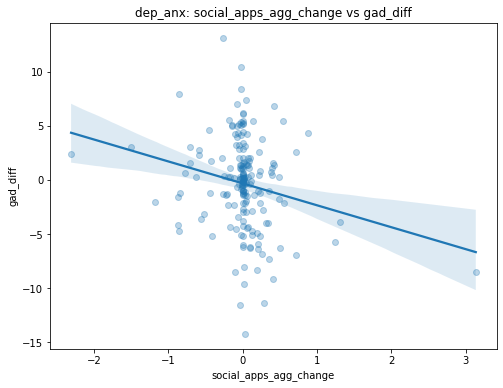

In [25]:
ls_utils.plot_cluster_scatter('social_apps_agg_change', 'gad_diff', gad_spin_corr, 'dep_anx', (8,6))

## Reverse GAD

### Full population

In [26]:
ls_utils.display_all_corr(change_rev_gad_spin_corr, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(change_rev_gad_spin_corr, agg_cols_change, 'gad_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,816,0.025036,0.4751,0.6797,fdr_bh
1,passive_apps_agg_change,gad_diff,816,-0.003244,0.9263,0.9263,fdr_bh
2,social_apps_agg_change,gad_diff,816,0.076467,0.0289*,0.2391,fdr_bh
3,work_dur_agg_change,gad_diff,815,-0.008940,0.7988,0.8559,fdr_bh
4,home_dur_agg_change,gad_diff,815,-0.042675,0.2236,0.5590,fdr_bh
5,religion_dur_agg_change,gad_diff,815,0.010627,0.7619,0.8559,fdr_bh
6,exercise_dur_agg_change,gad_diff,815,-0.037962,0.2790,0.5667,fdr_bh
7,shopping_dur_agg_change,gad_diff,815,-0.023747,0.4984,0.6797,fdr_bh
8,other_dur_agg_change,gad_diff,815,0.036182,0.3022,0.5667,fdr_bh
9,social_dur_agg_change,gad_diff,815,0.046892,0.1811,0.5433,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,816,0.030607,0.3826,0.5738,fdr_bh
1,passive_apps_agg_change,gad_diff,816,-0.031014,0.3763,0.5738,fdr_bh
2,social_apps_agg_change,gad_diff,816,0.072916,0.0373*,0.3596,fdr_bh
3,work_dur_agg_change,gad_diff,815,-0.031190,0.3739,0.5738,fdr_bh
4,home_dur_agg_change,gad_diff,815,-0.049140,0.1610,0.4831,fdr_bh
5,religion_dur_agg_change,gad_diff,815,-0.057617,0.1002,0.3759,fdr_bh
6,exercise_dur_agg_change,gad_diff,815,-0.021430,0.5412,0.6013,fdr_bh
7,shopping_dur_agg_change,gad_diff,815,0.009038,0.7967,0.7967,fdr_bh
8,other_dur_agg_change,gad_diff,815,0.038895,0.2674,0.5738,fdr_bh
9,social_dur_agg_change,gad_diff,815,0.059993,0.0870*,0.3759,fdr_bh


### no_symp

In [27]:
rev_sel_state_df = change_rev_gad_spin_corr[change_rev_gad_spin_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,215,0.091419,0.1817,0.3884,fdr_bh
1,passive_apps_agg_change,gad_diff,215,0.008123,0.9057,0.9154,fdr_bh
2,social_apps_agg_change,gad_diff,215,-0.011992,0.8612,0.9154,fdr_bh
3,work_dur_agg_change,gad_diff,215,0.007289,0.9154,0.9154,fdr_bh
4,home_dur_agg_change,gad_diff,215,-0.043879,0.5222,0.7121,fdr_bh
5,religion_dur_agg_change,gad_diff,215,-0.057564,0.4010,0.6455,fdr_bh
6,exercise_dur_agg_change,gad_diff,215,0.027350,0.6901,0.8626,fdr_bh
7,shopping_dur_agg_change,gad_diff,215,-0.112051,0.1013,0.3039,fdr_bh
8,other_dur_agg_change,gad_diff,215,0.128788,0.0594*,0.2227,fdr_bh
9,social_dur_agg_change,gad_diff,215,0.086378,0.2071,0.3884,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,215,0.107049,0.1176,0.6643,fdr_bh
1,passive_apps_agg_change,gad_diff,215,-0.069891,0.3077,0.6643,fdr_bh
2,social_apps_agg_change,gad_diff,215,-0.013954,0.8388,0.8388,fdr_bh
3,work_dur_agg_change,gad_diff,215,-0.039257,0.5670,0.7751,fdr_bh
4,home_dur_agg_change,gad_diff,215,-0.072870,0.2875,0.6643,fdr_bh
5,religion_dur_agg_change,gad_diff,215,-0.057859,0.3986,0.6643,fdr_bh
6,exercise_dur_agg_change,gad_diff,215,0.026306,0.7013,0.8252,fdr_bh
7,shopping_dur_agg_change,gad_diff,215,-0.062591,0.3611,0.6643,fdr_bh
8,other_dur_agg_change,gad_diff,215,0.063043,0.3576,0.6643,fdr_bh
9,social_dur_agg_change,gad_diff,215,0.087470,0.2014,0.6643,fdr_bh


### soc_anx

In [28]:
rev_sel_state_df = change_rev_gad_spin_corr[change_rev_gad_spin_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,231,-0.046908,0.4780,0.7500,fdr_bh
1,passive_apps_agg_change,gad_diff,231,0.020930,0.7517,0.8673,fdr_bh
2,social_apps_agg_change,gad_diff,231,0.191513,0.0035*,0.0522*,fdr_bh
3,work_dur_agg_change,gad_diff,231,0.095046,0.1499,0.5620,fdr_bh
4,home_dur_agg_change,gad_diff,231,0.006719,0.9191,0.9191,fdr_bh
5,religion_dur_agg_change,gad_diff,231,0.097806,0.1383,0.5620,fdr_bh
6,exercise_dur_agg_change,gad_diff,231,-0.072824,0.2703,0.6758,fdr_bh
7,shopping_dur_agg_change,gad_diff,231,0.041150,0.5337,0.7500,fdr_bh
8,other_dur_agg_change,gad_diff,231,0.006919,0.9167,0.9191,fdr_bh
9,social_dur_agg_change,gad_diff,231,0.097651,0.1390,0.5620,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,231,-0.061698,0.3505,0.4703,fdr_bh
1,passive_apps_agg_change,gad_diff,231,-0.061743,0.3502,0.4703,fdr_bh
2,social_apps_agg_change,gad_diff,231,0.200017,0.0023*,0.0338*,fdr_bh
3,work_dur_agg_change,gad_diff,231,0.113713,0.0846*,0.2561,fdr_bh
4,home_dur_agg_change,gad_diff,231,0.048638,0.4619,0.5330,fdr_bh
5,religion_dur_agg_change,gad_diff,231,0.110249,0.0946*,0.2561,fdr_bh
6,exercise_dur_agg_change,gad_diff,231,0.044067,0.5051,0.5333,fdr_bh
7,shopping_dur_agg_change,gad_diff,231,0.159746,0.0151*,0.1131,fdr_bh
8,other_dur_agg_change,gad_diff,231,0.102719,0.1195,0.2561,fdr_bh
9,social_dur_agg_change,gad_diff,231,0.125133,0.0576*,0.2561,fdr_bh


### gen_anx

In [29]:
rev_sel_state_df = change_rev_gad_spin_corr[change_rev_gad_spin_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,221,0.049399,0.4650,0.6975,fdr_bh
1,passive_apps_agg_change,gad_diff,221,-0.033931,0.6159,0.7952,fdr_bh
2,social_apps_agg_change,gad_diff,221,0.085746,0.2041,0.6975,fdr_bh
3,work_dur_agg_change,gad_diff,221,-0.082597,0.2213,0.6975,fdr_bh
4,home_dur_agg_change,gad_diff,221,-0.060224,0.3729,0.6975,fdr_bh
5,religion_dur_agg_change,gad_diff,221,-0.013636,0.8402,0.8402,fdr_bh
6,exercise_dur_agg_change,gad_diff,221,-0.095847,0.1556,0.6975,fdr_bh
7,shopping_dur_agg_change,gad_diff,221,-0.051977,0.4420,0.6975,fdr_bh
8,other_dur_agg_change,gad_diff,221,-0.016554,0.8067,0.8402,fdr_bh
9,social_dur_agg_change,gad_diff,221,0.066460,0.3254,0.6975,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,221,0.043915,0.5160,0.8201,fdr_bh
1,passive_apps_agg_change,gad_diff,221,0.040751,0.5468,0.8201,fdr_bh
2,social_apps_agg_change,gad_diff,221,0.098972,0.1425,0.7014,fdr_bh
3,work_dur_agg_change,gad_diff,221,-0.138074,0.0403*,0.3512,fdr_bh
4,home_dur_agg_change,gad_diff,221,-0.052546,0.4370,0.8201,fdr_bh
5,religion_dur_agg_change,gad_diff,221,-0.089081,0.1870,0.7014,fdr_bh
6,exercise_dur_agg_change,gad_diff,221,-0.133876,0.0468*,0.3512,fdr_bh
7,shopping_dur_agg_change,gad_diff,221,-0.047726,0.4803,0.8201,fdr_bh
8,other_dur_agg_change,gad_diff,221,0.007071,0.9168,0.9168,fdr_bh
9,social_dur_agg_change,gad_diff,221,0.049157,0.4672,0.8201,fdr_bh


### dep_anx

In [30]:
rev_sel_state_df = change_rev_gad_spin_corr[change_rev_gad_spin_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,149,0.067797,0.4113,0.6619,fdr_bh
1,passive_apps_agg_change,gad_diff,149,-0.018420,0.8236,0.8824,fdr_bh
2,social_apps_agg_change,gad_diff,149,0.072729,0.3781,0.6619,fdr_bh
3,work_dur_agg_change,gad_diff,148,-0.098060,0.2357,0.6619,fdr_bh
4,home_dur_agg_change,gad_diff,148,-0.092752,0.2622,0.6619,fdr_bh
5,religion_dur_agg_change,gad_diff,148,-0.119874,0.1467,0.6619,fdr_bh
6,exercise_dur_agg_change,gad_diff,148,0.010802,0.8963,0.8963,fdr_bh
7,shopping_dur_agg_change,gad_diff,148,0.022101,0.7898,0.8824,fdr_bh
8,other_dur_agg_change,gad_diff,148,0.034229,0.6796,0.8495,fdr_bh
9,social_dur_agg_change,gad_diff,148,-0.063776,0.4413,0.6619,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,149,0.052875,0.5219,0.9804,fdr_bh
1,passive_apps_agg_change,gad_diff,149,-0.077734,0.3460,0.8651,fdr_bh
2,social_apps_agg_change,gad_diff,149,-0.035576,0.6667,0.9804,fdr_bh
3,work_dur_agg_change,gad_diff,148,-0.092894,0.2615,0.7844,fdr_bh
4,home_dur_agg_change,gad_diff,148,-0.135364,0.1009,0.6005,fdr_bh
5,religion_dur_agg_change,gad_diff,148,-0.227958,0.0053*,0.0799*,fdr_bh
6,exercise_dur_agg_change,gad_diff,148,-0.020669,0.8031,0.9804,fdr_bh
7,shopping_dur_agg_change,gad_diff,148,0.002036,0.9804,0.9804,fdr_bh
8,other_dur_agg_change,gad_diff,148,-0.007736,0.9257,0.9804,fdr_bh
9,social_dur_agg_change,gad_diff,148,-0.036515,0.6595,0.9804,fdr_bh


## PHQ

### Entire population

In [31]:
ls_utils.display_all_corr(change_phq_corr, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(change_phq_corr, agg_cols_change, 'phq_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,866,-0.046493,0.1716,0.2861,fdr_bh
1,passive_apps_agg_change,phq_diff,866,0.035111,0.3020,0.3808,fdr_bh
2,social_apps_agg_change,phq_diff,866,0.071479,0.0355*,0.0886*,fdr_bh
3,work_dur_agg_change,phq_diff,866,0.018275,0.5912,0.6335,fdr_bh
4,home_dur_agg_change,phq_diff,866,0.069303,0.0415*,0.0888*,fdr_bh
5,religion_dur_agg_change,phq_diff,866,-0.040149,0.2379,0.3568,fdr_bh
6,exercise_dur_agg_change,phq_diff,866,0.121725,0.0003*,0.0012*,fdr_bh
7,shopping_dur_agg_change,phq_diff,866,-0.001222,0.9713,0.9713,fdr_bh
8,other_dur_agg_change,phq_diff,866,-0.057891,0.0886*,0.1662,fdr_bh
9,social_dur_agg_change,phq_diff,866,-0.076936,0.0236*,0.0707*,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,866,-0.046235,0.1740,0.2373,fdr_bh
1,passive_apps_agg_change,phq_diff,866,0.039840,0.2415,0.3019,fdr_bh
2,social_apps_agg_change,phq_diff,866,0.082458,0.0152*,0.0380*,fdr_bh
3,work_dur_agg_change,phq_diff,866,-0.023128,0.4967,0.5731,fdr_bh
4,home_dur_agg_change,phq_diff,866,0.084637,0.0127*,0.0380*,fdr_bh
5,religion_dur_agg_change,phq_diff,866,-0.048953,0.1500,0.2373,fdr_bh
6,exercise_dur_agg_change,phq_diff,866,0.090693,0.0076*,0.0284*,fdr_bh
7,shopping_dur_agg_change,phq_diff,866,-0.011022,0.7460,0.7460,fdr_bh
8,other_dur_agg_change,phq_diff,866,-0.075777,0.0258*,0.0552*,fdr_bh
9,social_dur_agg_change,phq_diff,866,-0.046605,0.1706,0.2373,fdr_bh


### no_symp

In [32]:
sel_state_df = change_phq_corr[change_phq_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,232,-0.112148,0.0883*,0.3312,fdr_bh
1,passive_apps_agg_change,phq_diff,232,0.015504,0.8143,0.9668,fdr_bh
2,social_apps_agg_change,phq_diff,232,-0.020868,0.7519,0.9668,fdr_bh
3,work_dur_agg_change,phq_diff,232,-0.099061,0.1325,0.3974,fdr_bh
4,home_dur_agg_change,phq_diff,232,-0.142777,0.0297*,0.2332,fdr_bh
5,religion_dur_agg_change,phq_diff,232,-0.130768,0.0466*,0.2332,fdr_bh
6,exercise_dur_agg_change,phq_diff,232,0.024621,0.7091,0.9668,fdr_bh
7,shopping_dur_agg_change,phq_diff,232,-0.010573,0.8727,0.9668,fdr_bh
8,other_dur_agg_change,phq_diff,232,0.022129,0.7374,0.9668,fdr_bh
9,social_dur_agg_change,phq_diff,232,-0.019100,0.7723,0.9668,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,232,-0.048051,0.4664,0.8840,fdr_bh
1,passive_apps_agg_change,phq_diff,232,-0.017265,0.7937,0.8840,fdr_bh
2,social_apps_agg_change,phq_diff,232,-0.009630,0.8840,0.8840,fdr_bh
3,work_dur_agg_change,phq_diff,232,-0.127402,0.0526*,0.3289,fdr_bh
4,home_dur_agg_change,phq_diff,232,-0.078251,0.2351,0.7054,fdr_bh
5,religion_dur_agg_change,phq_diff,232,-0.129620,0.0486*,0.3289,fdr_bh
6,exercise_dur_agg_change,phq_diff,232,-0.042359,0.5209,0.8840,fdr_bh
7,shopping_dur_agg_change,phq_diff,232,-0.022736,0.7305,0.8840,fdr_bh
8,other_dur_agg_change,phq_diff,232,-0.121002,0.0658*,0.3289,fdr_bh
9,social_dur_agg_change,phq_diff,232,0.013102,0.8427,0.8840,fdr_bh


### soc_anx

In [33]:
sel_state_df = change_phq_corr[change_phq_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,235,0.108457,0.0972*,0.2083,fdr_bh
1,passive_apps_agg_change,phq_diff,235,-0.059790,0.3615,0.4458,fdr_bh
2,social_apps_agg_change,phq_diff,235,0.091132,0.1638,0.2730,fdr_bh
3,work_dur_agg_change,phq_diff,235,0.101267,0.1216,0.2280,fdr_bh
4,home_dur_agg_change,phq_diff,235,0.169272,0.0093*,0.0350*,fdr_bh
5,religion_dur_agg_change,phq_diff,235,-0.022401,0.7326,0.7326,fdr_bh
6,exercise_dur_agg_change,phq_diff,235,0.150792,0.0207*,0.0622*,fdr_bh
7,shopping_dur_agg_change,phq_diff,235,-0.053291,0.4161,0.4458,fdr_bh
8,other_dur_agg_change,phq_diff,235,-0.078451,0.2309,0.3148,fdr_bh
9,social_dur_agg_change,phq_diff,235,-0.211372,0.0011*,0.0134*,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,235,0.080846,0.2169,0.3332,fdr_bh
1,passive_apps_agg_change,phq_diff,235,0.049392,0.4511,0.6151,fdr_bh
2,social_apps_agg_change,phq_diff,235,0.079945,0.2221,0.3332,fdr_bh
3,work_dur_agg_change,phq_diff,235,0.028227,0.6668,0.7370,fdr_bh
4,home_dur_agg_change,phq_diff,235,0.216372,0.0008*,0.0126*,fdr_bh
5,religion_dur_agg_change,phq_diff,235,0.099183,0.1295,0.2428,fdr_bh
6,exercise_dur_agg_change,phq_diff,235,0.172180,0.0082*,0.0408*,fdr_bh
7,shopping_dur_agg_change,phq_diff,235,-0.026346,0.6878,0.7370,fdr_bh
8,other_dur_agg_change,phq_diff,235,0.006079,0.9261,0.9261,fdr_bh
9,social_dur_agg_change,phq_diff,235,-0.151879,0.0198*,0.0558*,fdr_bh


### gen_anx

In [34]:
sel_state_df = change_phq_corr[change_phq_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,235,0.014755,0.8220,0.9821,fdr_bh
1,passive_apps_agg_change,phq_diff,235,0.137397,0.0353*,0.1059,fdr_bh
2,social_apps_agg_change,phq_diff,235,0.151437,0.0202*,0.0865*,fdr_bh
3,work_dur_agg_change,phq_diff,235,0.074998,0.2521,0.4850,fdr_bh
4,home_dur_agg_change,phq_diff,235,0.090911,0.1648,0.4120,fdr_bh
5,religion_dur_agg_change,phq_diff,235,-0.011625,0.8593,0.9821,fdr_bh
6,exercise_dur_agg_change,phq_diff,235,0.148188,0.0231*,0.0865*,fdr_bh
7,shopping_dur_agg_change,phq_diff,235,0.069171,0.2910,0.4850,fdr_bh
8,other_dur_agg_change,phq_diff,235,-0.057040,0.3841,0.5237,fdr_bh
9,social_dur_agg_change,phq_diff,235,-0.006865,0.9166,0.9821,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,235,-0.067184,0.3051,0.4741,fdr_bh
1,passive_apps_agg_change,phq_diff,235,0.103092,0.1150,0.2573,fdr_bh
2,social_apps_agg_change,phq_diff,235,0.157494,0.0157*,0.1091,fdr_bh
3,work_dur_agg_change,phq_diff,235,0.011819,0.8570,0.9182,fdr_bh
4,home_dur_agg_change,phq_diff,235,0.099277,0.1291,0.2573,fdr_bh
5,religion_dur_agg_change,phq_diff,235,-0.065676,0.3161,0.4741,fdr_bh
6,exercise_dur_agg_change,phq_diff,235,0.142377,0.0291*,0.1091,fdr_bh
7,shopping_dur_agg_change,phq_diff,235,-0.003705,0.9549,0.9549,fdr_bh
8,other_dur_agg_change,phq_diff,235,-0.034569,0.5980,0.7475,fdr_bh
9,social_dur_agg_change,phq_diff,235,0.022059,0.7366,0.8499,fdr_bh


### dep_anx

In [35]:
sel_state_df = change_phq_corr[change_phq_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,164,-0.330117,0.0000*,0.0001*,fdr_bh
1,passive_apps_agg_change,phq_diff,164,0.046980,0.5503,0.6878,fdr_bh
2,social_apps_agg_change,phq_diff,164,0.047225,0.5482,0.6878,fdr_bh
3,work_dur_agg_change,phq_diff,164,-0.074707,0.3417,0.5696,fdr_bh
4,home_dur_agg_change,phq_diff,164,0.153114,0.0503*,0.1078,fdr_bh
5,religion_dur_agg_change,phq_diff,164,0.009667,0.9022,0.9285,fdr_bh
6,exercise_dur_agg_change,phq_diff,164,0.216433,0.0054*,0.0134*,fdr_bh
7,shopping_dur_agg_change,phq_diff,164,-0.056959,0.4688,0.6878,fdr_bh
8,other_dur_agg_change,phq_diff,164,-0.227476,0.0034*,0.0127*,fdr_bh
9,social_dur_agg_change,phq_diff,164,-0.117461,0.1342,0.2515,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,164,-0.187635,0.0161*,0.0605*,fdr_bh
1,passive_apps_agg_change,phq_diff,164,-0.007836,0.9207,0.9207,fdr_bh
2,social_apps_agg_change,phq_diff,164,0.056547,0.4720,0.6437,fdr_bh
3,work_dur_agg_change,phq_diff,164,-0.040869,0.6033,0.7542,fdr_bh
4,home_dur_agg_change,phq_diff,164,0.103548,0.1870,0.4007,fdr_bh
5,religion_dur_agg_change,phq_diff,164,-0.089169,0.2562,0.4394,fdr_bh
6,exercise_dur_agg_change,phq_diff,164,0.114966,0.1427,0.3567,fdr_bh
7,shopping_dur_agg_change,phq_diff,164,0.013768,0.8611,0.9207,fdr_bh
8,other_dur_agg_change,phq_diff,164,-0.180182,0.0210*,0.0629*,fdr_bh
9,social_dur_agg_change,phq_diff,164,-0.064326,0.4132,0.6198,fdr_bh


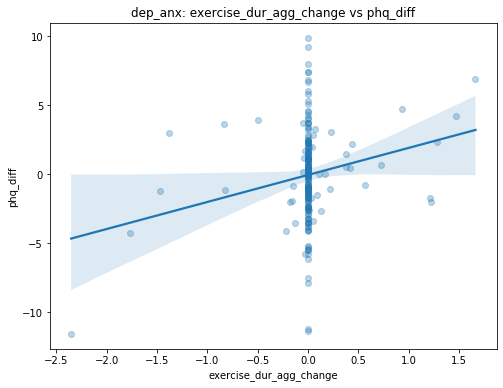

In [36]:
ls_utils.plot_cluster_scatter('exercise_dur_agg_change', 'phq_diff', phq_corr, 'dep_anx', (8,6))

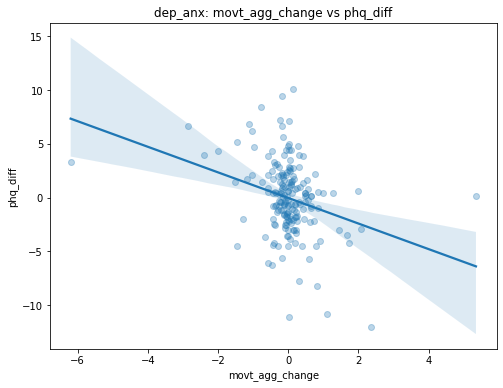

In [37]:
ls_utils.plot_cluster_scatter('movt_agg_change', 'phq_diff', phq_corr, 'dep_anx', (8,6))

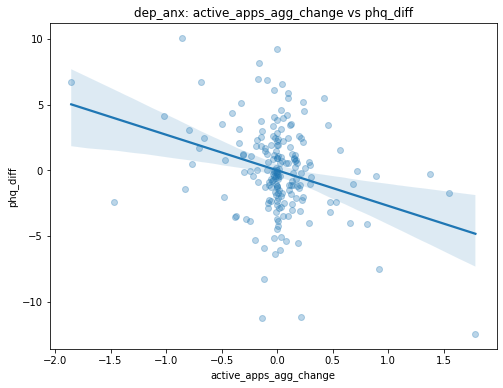

In [38]:
ls_utils.plot_cluster_scatter('active_apps_agg_change', 'phq_diff', phq_corr, 'dep_anx', (8,6))

## Reverse PHQ

### Full population

In [39]:
ls_utils.display_all_corr(change_rev_phq_corr, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(change_rev_phq_corr, agg_cols_change, 'phq_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,866,-0.001800,0.9578,0.9578,fdr_bh
1,passive_apps_agg_change,phq_diff,866,-0.069265,0.0416*,0.2078,fdr_bh
2,social_apps_agg_change,phq_diff,866,-0.020271,0.5514,0.8847,fdr_bh
3,work_dur_agg_change,phq_diff,865,-0.017793,0.6013,0.8847,fdr_bh
4,home_dur_agg_change,phq_diff,865,0.022811,0.5028,0.8847,fdr_bh
5,religion_dur_agg_change,phq_diff,865,-0.081851,0.0160*,0.2078,fdr_bh
6,exercise_dur_agg_change,phq_diff,865,-0.074010,0.0295*,0.2078,fdr_bh
7,shopping_dur_agg_change,phq_diff,865,-0.011133,0.7437,0.9188,fdr_bh
8,other_dur_agg_change,phq_diff,865,-0.038245,0.2612,0.7835,fdr_bh
9,social_dur_agg_change,phq_diff,865,-0.032496,0.3398,0.8495,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,866,-0.006174,0.8560,0.9826,fdr_bh
1,passive_apps_agg_change,phq_diff,866,-0.050160,0.1402,0.9826,fdr_bh
2,social_apps_agg_change,phq_diff,866,-0.019655,0.5635,0.9826,fdr_bh
3,work_dur_agg_change,phq_diff,865,-0.036613,0.2821,0.9826,fdr_bh
4,home_dur_agg_change,phq_diff,865,0.000741,0.9826,0.9826,fdr_bh
5,religion_dur_agg_change,phq_diff,865,-0.074122,0.0293*,0.4390,fdr_bh
6,exercise_dur_agg_change,phq_diff,865,-0.009053,0.7903,0.9826,fdr_bh
7,shopping_dur_agg_change,phq_diff,865,0.017866,0.5998,0.9826,fdr_bh
8,other_dur_agg_change,phq_diff,865,-0.012735,0.7084,0.9826,fdr_bh
9,social_dur_agg_change,phq_diff,865,-0.032221,0.3439,0.9826,fdr_bh


### no_symp

In [40]:
sel_state_df = change_rev_phq_corr[change_rev_phq_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,232,-0.119739,0.0687*,0.4495,fdr_bh
1,passive_apps_agg_change,phq_diff,232,0.039588,0.5485,0.7091,fdr_bh
2,social_apps_agg_change,phq_diff,232,0.036914,0.5759,0.7091,fdr_bh
3,work_dur_agg_change,phq_diff,231,-0.020244,0.7596,0.7596,fdr_bh
4,home_dur_agg_change,phq_diff,231,0.102742,0.1194,0.4495,fdr_bh
5,religion_dur_agg_change,phq_diff,231,-0.060994,0.3561,0.6536,fdr_bh
6,exercise_dur_agg_change,phq_diff,231,-0.078628,0.2339,0.5847,fdr_bh
7,shopping_dur_agg_change,phq_diff,231,-0.030869,0.6407,0.7091,fdr_bh
8,other_dur_agg_change,phq_diff,231,-0.030325,0.6466,0.7091,fdr_bh
9,social_dur_agg_change,phq_diff,231,-0.028929,0.6618,0.7091,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,232,-0.114123,0.0828*,0.4934,fdr_bh
1,passive_apps_agg_change,phq_diff,232,0.169752,0.0096*,0.1438,fdr_bh
2,social_apps_agg_change,phq_diff,232,0.083213,0.2067,0.4934,fdr_bh
3,work_dur_agg_change,phq_diff,231,-0.016735,0.8003,0.8574,fdr_bh
4,home_dur_agg_change,phq_diff,231,0.073925,0.2631,0.4934,fdr_bh
5,religion_dur_agg_change,phq_diff,231,0.001709,0.9794,0.9794,fdr_bh
6,exercise_dur_agg_change,phq_diff,231,-0.095358,0.1485,0.4934,fdr_bh
7,shopping_dur_agg_change,phq_diff,231,0.055255,0.4032,0.5902,fdr_bh
8,other_dur_agg_change,phq_diff,231,0.049875,0.4506,0.5902,fdr_bh
9,social_dur_agg_change,phq_diff,231,-0.075531,0.2529,0.4934,fdr_bh


### soc_anx

In [41]:
sel_state_df = change_rev_phq_corr[change_rev_phq_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,235,0.019516,0.7660,0.8207,fdr_bh
1,passive_apps_agg_change,phq_diff,235,-0.084051,0.1992,0.7167,fdr_bh
2,social_apps_agg_change,phq_diff,235,0.043126,0.5106,0.7409,fdr_bh
3,work_dur_agg_change,phq_diff,235,-0.059536,0.3636,0.7167,fdr_bh
4,home_dur_agg_change,phq_diff,235,-0.003438,0.9582,0.9582,fdr_bh
5,religion_dur_agg_change,phq_diff,235,-0.106678,0.1028,0.6155,fdr_bh
6,exercise_dur_agg_change,phq_diff,235,-0.126682,0.0524*,0.6155,fdr_bh
7,shopping_dur_agg_change,phq_diff,235,0.067698,0.3014,0.7167,fdr_bh
8,other_dur_agg_change,phq_diff,235,0.057257,0.3822,0.7167,fdr_bh
9,social_dur_agg_change,phq_diff,235,0.026315,0.6882,0.7941,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,235,-0.016312,0.8036,0.8036,fdr_bh
1,passive_apps_agg_change,phq_diff,235,-0.080521,0.2188,0.8036,fdr_bh
2,social_apps_agg_change,phq_diff,235,0.018748,0.7750,0.8036,fdr_bh
3,work_dur_agg_change,phq_diff,235,-0.039516,0.5467,0.8036,fdr_bh
4,home_dur_agg_change,phq_diff,235,-0.039731,0.5445,0.8036,fdr_bh
5,religion_dur_agg_change,phq_diff,235,-0.054811,0.4029,0.8036,fdr_bh
6,exercise_dur_agg_change,phq_diff,235,0.016569,0.8005,0.8036,fdr_bh
7,shopping_dur_agg_change,phq_diff,235,0.131108,0.0447*,0.6700,fdr_bh
8,other_dur_agg_change,phq_diff,235,0.020830,0.7508,0.8036,fdr_bh
9,social_dur_agg_change,phq_diff,235,0.050700,0.4392,0.8036,fdr_bh


### gen_anx

In [42]:
sel_state_df = change_rev_phq_corr[change_rev_phq_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,235,0.002501,0.9696,0.9748,fdr_bh
1,passive_apps_agg_change,phq_diff,235,-0.117497,0.0722*,0.2708,fdr_bh
2,social_apps_agg_change,phq_diff,235,-0.026635,0.6846,0.8557,fdr_bh
3,work_dur_agg_change,phq_diff,235,-0.033864,0.6055,0.8557,fdr_bh
4,home_dur_agg_change,phq_diff,235,0.010035,0.8784,0.9748,fdr_bh
5,religion_dur_agg_change,phq_diff,235,-0.119191,0.0682*,0.2708,fdr_bh
6,exercise_dur_agg_change,phq_diff,235,-0.029424,0.6536,0.8557,fdr_bh
7,shopping_dur_agg_change,phq_diff,235,-0.046970,0.4736,0.8557,fdr_bh
8,other_dur_agg_change,phq_diff,235,-0.152205,0.0196*,0.1468,fdr_bh
9,social_dur_agg_change,phq_diff,235,-0.028801,0.6605,0.8557,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,235,0.034265,0.6012,0.7821,fdr_bh
1,passive_apps_agg_change,phq_diff,235,-0.082187,0.2094,0.6981,fdr_bh
2,social_apps_agg_change,phq_diff,235,-0.033669,0.6076,0.7821,fdr_bh
3,work_dur_agg_change,phq_diff,235,-0.080361,0.2197,0.6981,fdr_bh
4,home_dur_agg_change,phq_diff,235,0.002012,0.9755,0.9755,fdr_bh
5,religion_dur_agg_change,phq_diff,235,-0.171872,0.0083*,0.1242,fdr_bh
6,exercise_dur_agg_change,phq_diff,235,0.018137,0.7821,0.8883,fdr_bh
7,shopping_dur_agg_change,phq_diff,235,-0.070873,0.2792,0.6981,fdr_bh
8,other_dur_agg_change,phq_diff,235,-0.074106,0.2578,0.6981,fdr_bh
9,social_dur_agg_change,phq_diff,235,-0.031982,0.6257,0.7821,fdr_bh


### dep_anx

In [43]:
sel_state_df = change_rev_phq_corr[change_rev_phq_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,164,0.115163,0.1420,0.6122,fdr_bh
1,passive_apps_agg_change,phq_diff,164,-0.105170,0.1802,0.6122,fdr_bh
2,social_apps_agg_change,phq_diff,164,-0.108425,0.1670,0.6122,fdr_bh
3,work_dur_agg_change,phq_diff,164,0.091407,0.2444,0.6122,fdr_bh
4,home_dur_agg_change,phq_diff,164,-0.015874,0.8401,0.8799,fdr_bh
5,religion_dur_agg_change,phq_diff,164,0.011894,0.8799,0.8799,fdr_bh
6,exercise_dur_agg_change,phq_diff,164,-0.037969,0.6293,0.8582,fdr_bh
7,shopping_dur_agg_change,phq_diff,164,-0.077731,0.3225,0.6911,fdr_bh
8,other_dur_agg_change,phq_diff,164,0.020438,0.7950,0.8799,fdr_bh
9,social_dur_agg_change,phq_diff,164,-0.091312,0.2449,0.6122,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,164,0.100349,0.2011,0.5027,fdr_bh
1,passive_apps_agg_change,phq_diff,164,-0.159795,0.0410*,0.3686,fdr_bh
2,social_apps_agg_change,phq_diff,164,-0.140026,0.0737*,0.3686,fdr_bh
3,work_dur_agg_change,phq_diff,164,-0.016120,0.8377,0.8824,fdr_bh
4,home_dur_agg_change,phq_diff,164,-0.032691,0.6777,0.8574,fdr_bh
5,religion_dur_agg_change,phq_diff,164,-0.025791,0.7431,0.8574,fdr_bh
6,exercise_dur_agg_change,phq_diff,164,0.087924,0.2629,0.5634,fdr_bh
7,shopping_dur_agg_change,phq_diff,164,-0.011643,0.8824,0.8824,fdr_bh
8,other_dur_agg_change,phq_diff,164,-0.026896,0.7325,0.8574,fdr_bh
9,social_dur_agg_change,phq_diff,164,-0.069623,0.3757,0.7044,fdr_bh


# Reviewer I: Global model results TODO

# Reviewer I: Autocorrelation tests TODO

## Durbin-Watson for PHQ

In [44]:
pids = phq_corr['pid'].unique()

#dw_stats = [durbin_watson(phq_corr[phq_corr['pid'] == pid]['phq_diff']) for pid in pids]

dw_stats = []
for pid in pids:
    diffs = phq_corr[phq_corr['pid'] == pid]['phq_diff'].dropna()
    dw_stats.append(durbin_watson(diffs))

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/statsmodels/stats/stattools.py:46: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


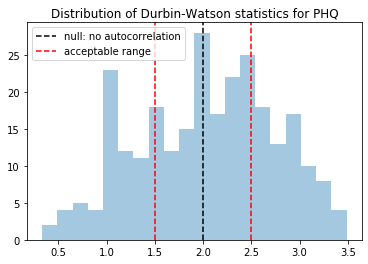

In [52]:
sns.distplot(dw_stats, kde=False, bins=20)
plt.title("Distribution of Durbin-Watson statistics for PHQ")
          
plt.axvline(x=2, label="null: no autocorrelation", color='black', ls='--')
plt.axvline(x=1.5, label="acceptable range", color='red', ls='--')
plt.axvline(x=2.5, color='red', ls='--')
plt.legend()

## Durbin-Watson for GAD

In [54]:
pids = gad_spin_corr['pid'].unique()

dw_stats = []
for pid in pids:
    diffs = gad_spin_corr[gad_spin_corr['pid'] == pid]['gad_diff'].dropna()
    dw_stats.append(durbin_watson(diffs))

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/statsmodels/stats/stattools.py:46: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


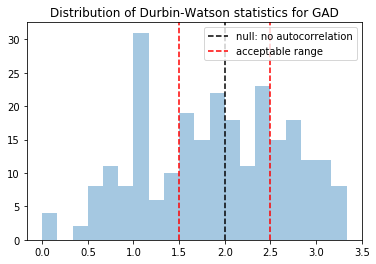

In [55]:
sns.distplot(dw_stats, kde=False, bins=20)
plt.title("Distribution of Durbin-Watson statistics for GAD")
          
plt.axvline(x=2, label="null: no autocorrelation", color='black', ls='--')
plt.axvline(x=1.5, label="acceptable range", color='red', ls='--')
plt.axvline(x=2.5, color='red', ls='--')
plt.legend()

## Durbin-Watson for SPIN

In [56]:
pids = gad_spin_corr['pid'].unique()

dw_stats = []
for pid in pids:
    diffs = gad_spin_corr[gad_spin_corr['pid'] == pid]['spin_diff'].dropna()
    dw_stats.append(durbin_watson(diffs))

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/statsmodels/stats/stattools.py:46: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


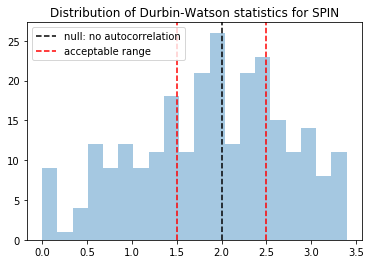

In [58]:
sns.distplot(dw_stats, kde=False, bins=20)
plt.title("Distribution of Durbin-Watson statistics for SPIN")
          
plt.axvline(x=2, label="null: no autocorrelation", color='black', ls='--')
plt.axvline(x=1.5, label="acceptable range", color='red', ls='--')
plt.axvline(x=2.5, color='red', ls='--')
plt.legend()

# Reviewer J: Missingness analysis TODO

# Reviewer J: Partial correlation with baseline severity as covariate TODO

# Notes

- old pingouin version is 0.3.7, upgraded to 0.3.8